In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
from scipy.stats import norm
rng = default_rng(44811073180058189346296543024438785297)

In [2]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return mean, var, mean - ci_size, mean + ci_size

<font color=black size=6 >1. Black-Scholes Model, Put, d=1</font>

In [3]:
r = 0.1
sigma = 0.25
x0 = 100.
K = 100.
# N, T = 30, 30/365
N, T = 10, 1

<font color=black size=5 >1.1 Explicite calculation of price and delta</font>

In [4]:
def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

def price_put_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return strike * np.exp(-r * t) * norm.cdf(-d2_) - spot * norm.cdf(-d1_)

def dprice_put_BS(spot, t, r=r, sigma=sigma, strike=K):
    return dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K) - 1

In [5]:
print('The price for this put is {:.3f}, and the delta for this put at t0 is {:.3f}'.format(
    price_put_BS(x0, T, r, sigma, K), dprice_put_BS(x0, T, r, sigma, K)
))

The price for this put is 5.460, and the delta for this put at t0 is -0.300


<font color=black size=5 >1.2 Simulatation of price and delta</font>

In [6]:
def simu_S(N, M): 
    h = T/N
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N+1, M))
    sample[0] = x0
    for n in range(1, N+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [7]:
M=int(1e6)
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

In [8]:
p = 0.95
mean, var, lower, upper = monte_carlo(np.exp(-r*T)*np.maximum(K - sample[N], 0),p)
print('The MC simulation for this put at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f}'.
     format(p, lower, upper, mean, var))

The MC simulation for this put at 95% confidence level is [5.43,5.47], 
with mean 5.45 and variance 84.64


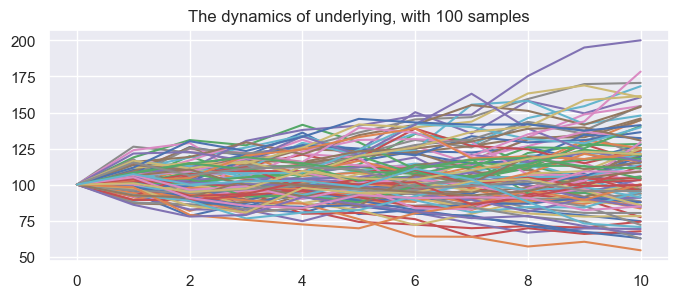

In [9]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(sample[:,:100])
plt.title('The dynamics of underlying, with 100 samples')
plt.show()

<font color=black size=5 >1.3 Without hedging, and delta hedging</font>

First, we take a look at, when we sell an option, and we don't do anything, i.e. with out hedging, and we plot the histogram of PnL, we can find that it has a great variance!

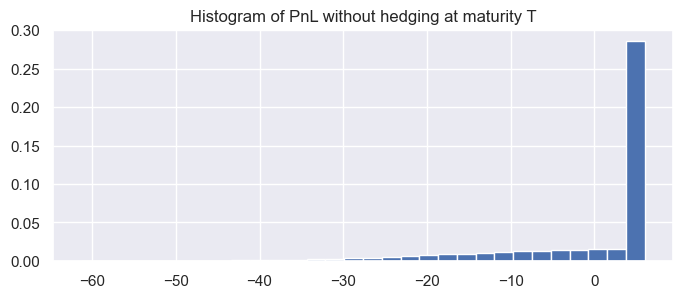

In [10]:
price_BS = price_put_BS(x0, T, r, sigma, K)
pnl_no_hedging = price_BS*np.exp(r*T) - np.maximum(K - sample[N], 0)
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(pnl_no_hedging, bins=30, density=True)
ax.set_title("Histogram of PnL without hedging at maturity T")
plt.show()

We plot also the histogramme of delta hedging of this Put option

In [11]:
delta = np.zeros_like(sample)
for n in range(N): 
    delta[n] = dprice_put_BS(sample[n], (N-n)*T/N)
pnl_delta_hedging = np.zeros_like(sample)
pnl_delta_hedging[0] = price_BS - delta[0] * sample_act[0]
for n in range(1,N):
    pnl_delta_hedging[n] = pnl_delta_hedging[n-1] - (delta[n] - delta[n-1]) * sample_act[n]
pnl_delta_hedging[N] = pnl_delta_hedging[N-1] + delta[N-1] * sample_act[N] - np.exp(-r*T)*np.maximum(K-sample[N], 0)



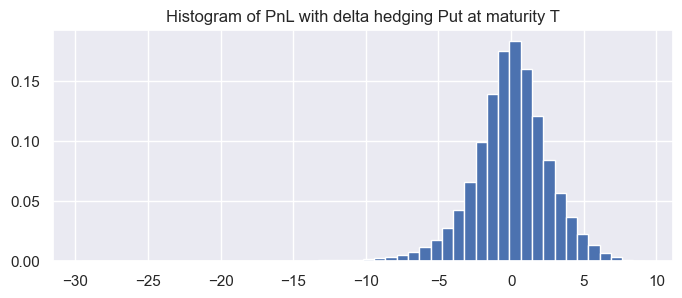

In [12]:
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(pnl_delta_hedging[N]*np.exp(r*T), bins=50, density=True)
ax.set_title("Histogram of PnL with delta hedging Put at maturity T")
plt.show()

In [13]:
p = 0.95
mean, var, lower, upper = monte_carlo(pnl_no_hedging,p)
print('The MC simulation for PnL no hedging of this put at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f}'.
     format(p, lower, upper, mean, var))

The MC simulation for PnL no hedging of this put at 95% confidence level is [-0.01,0.03], 
with mean 0.01 and variance 103.38


In [14]:
p = 0.95
mean, var, lower, upper = monte_carlo(pnl_delta_hedging[N]*np.exp(r*T),p)
print('The MC simulation for PnL delta hedging of this put at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f}'.
     format(p, lower, upper, mean, var))

The MC simulation for PnL delta hedging of this put at 95% confidence level is [-0.01,0.00], 
with mean -0.00 and variance 6.63


**We plot also the delta of this put option.**

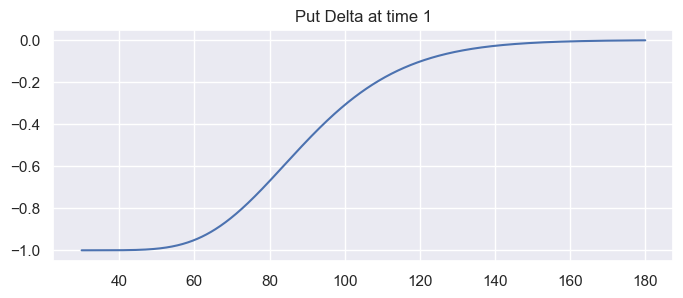

In [15]:
xx = np.linspace(30, 180, 1000)
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xx, dprice_put_BS(xx, (N-1)*T/N))
plt.title('Put Delta at time 1')
plt.show()

<font color=black size=5 >1.4 Deep hedging by neural network--Some functional code</font>

**We first define some important function and class that we will consistently use in this projet.**

In [16]:
import torch 
import torch.nn as nn
from tqdm import tqdm
from scipy import stats
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
class NNmodel(nn.Module):
    '''the basic fully connected layer model, and we will use this as a NN framework to train
    the hedging model'''
    def __init__(self, size_input, size_output, hidden_layers, normalization=True, activation='relu'):
        super().__init__()
        hidden_layers = [size_input, ] + hidden_layers
        hid = []
        if normalization:
            hid.append(nn.BatchNorm1d(size_input,affine=True))
        for i in range(len(hidden_layers)-1):
            hid.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            if activation=='relu':
                hid.append(nn.ReLU())
            elif activation == 'sigmoid':
                hid.append(nn.Sigmoid())
            elif activation == 'tanh':
                hid.append(nn.Tanh())
            elif activation =='leakyrelu':
                hid.append(nn.LeakyReLU())
            else:
                hid.append(nn.ReLU())
        self.hid = nn.Sequential(*hid)
        self.last = nn.Linear(hidden_layers[-1], size_output)

    def forward(self,x):
        hid = self.hid(x)
        return self.last(hid)

In [18]:
class Dataloader_simu_BS():
    '''generate BS path and payoff for neural network to train'''
    def __init__(self, x0, K, N, T, r, sigma, M, batch_size, divise_by, device='cpu', option='put'):
        self.x0 = x0
        self.K = K
        self.N = N
        self.T = T
        self.batch_size = batch_size
        self.dt = T/N
        self.M = M
        # self.seed = 44811073180058189346296543024438785297
        # self.rng = default_rng(self.seed)
        self.rng = rng
        self.r = r
        self.sigma = sigma
        self.device = device
        self.divise_by = divise_by
        assert option in ('put', 'call')
        self.option = option

    def __len__(self):
        return self.M

    def generate_path_payoff(self):
        B = np.sqrt(self.dt) * torch.randn(size=(self.N, self.M), device=self.device)
        S = torch.zeros(size=(self.N + 1, self.M))
        S[0] = self.x0
        for n in range(1, self.N + 1):
            S[n] = S[n - 1] * torch.exp((- 0.5 * self.sigma ** 2) * self.dt + self.sigma * B[n - 1])
        path = S.T
        if self.option=='call':
            payoff = (np.exp(-self.r * self.T) * torch.relu(np.exp(self.r * self.T) * S[self.N] - self.K))[:, None]
        else:
            payoff = (np.exp(-self.r * self.T) * torch.relu(self.K - np.exp(self.r * self.T) * S[self.N]))[:, None]
        return path / self.divise_by, payoff / self.divise_by

    def __iter__(self):
        self.path, self.payoff = self.generate_path_payoff()
        self.batch_actuel = 0
        self.indices = torch.arange(len(self.path))
        return self

    def __next__(self):
        if self.batch_actuel < self.M:
            batch_end = min(self.batch_actuel + self.batch_size, self.M)
            l = batch_end - self.batch_actuel
            indices = self.indices[self.batch_actuel:batch_end]
            self.batch_actuel = batch_end
            return self.path[indices], self.payoff[indices]
        else:
            raise StopIteration

In [19]:
class hedge_NN_different_model_1_dim(nn.Module):
    '''deep hedging NN model , each time step is a new model'''
    def __init__(self, N, input_size, layer_sizes, output_size, normalization, price=None):
        super().__init__()
        if price is None:
            self.price = nn.Parameter(torch.ones(1), requires_grad=True)
        else:
            self.price = nn.Parameter(torch.ones(1)*price, requires_grad=False)
        self.delta0 = nn.Parameter(torch.ones(1))
        self.delta = nn.ModuleList([
            NNmodel(input_size,output_size,layer_sizes,normalization=normalization) for n in range(1,N) 
        ])
    def forward(self, n, x, delta_last_time=None):
        x = x.view(x.shape[0],1)
        if n == 0: 
            return self.price, self.delta0.expand(x.shape[0], 1)
        else:
            return self.delta[n-1](x)

class hedge_NN_recurrent_model_1_dim(nn.Module):
    '''deep hedging NN model , only one single model but we add time as a parameter'''
    def __init__(self, N, input_size, layer_sizes, output_size, normalization, price=None):
        super().__init__()
        if price is None:
            self.price = nn.Parameter(torch.ones(1), requires_grad=True)
        else:
            self.price = nn.Parameter(torch.ones(1)*price, requires_grad=False)
        self.delta0 = nn.Parameter(torch.ones(1))
        self.delta = NNmodel(input_size+2, output_size,layer_sizes,normalization=normalization)
    def forward(self, n, x, delta_last_time=None):
        x = x.view(x.shape[0],1)
        if n == 0: 
            return self.price, self.delta0.expand(x.shape[0], 1)
        return self.delta(torch.cat([x, torch.full((x.shape[0],1), n), 
                                     delta_last_time.view((x.shape[0],1))], dim=1))

class hedge_NN_recurrent_model(nn.Module):
    '''Only one single model, the recurrent deep hedging model for multiple dimension'''
    def __init__(self, N, input_size, layer_sizes, output_size, normalization, price=None):
        super().__init__()
        self.dimension_S = input_size
        if price is None:
            self.price = nn.Parameter(torch.ones(1))
        else:
            self.price = nn.Parameter(torch.ones(1)*price, requires_grad=False)
        self.delta0 = nn.Parameter(torch.ones(self.dimension_S))
        self.delta = NNmodel(input_size*2 + 1, # input is: price(d), last time delta(d), and time(1)
                             output_size,layer_sizes,
                             normalization=normalization)
    
    def forward(self, n, x, delta_last_time=None):
        if n == 0: 
            return self.price, self.delta0.expand(x.shape[0], self.dimension_S)
        return self.delta(torch.cat([x.view(x.shape[0],self.dimension_S),
                                     delta_last_time.view((x.shape[0],self.dimension_S)),
                                     torch.full((x.shape[0],1), n)], dim=1))

In [20]:
def pnl_calculation(path, payoff, model): 
    '''this function takes torch tensor: path, payoff as input,
       and also a delta-generating model as input
       -path: 2 or 3 dimension, (batch_size * N_time * dimension) or (batch_size * N_time) if dim=1
       -payoff: batch_size * 1
       -model: (time, state) -> delta (or strategy)
    '''
    if path.dim() == 2:
        path = path.unsqueeze(-1)
    value = np.zeros_like(path[:,[0]])
    delta = []
    p0, delta0 = model(0, path[:,[0]])
    delta.append(delta0)
    value = p0 - torch.bmm(delta0.unsqueeze(1), path[:,[0]].transpose(1, 2)).squeeze(-1)
    for n in range(1,N):
        delta.append(model(n, path[:,[n]],delta[-1]))
        value -= torch.bmm((delta[n] - delta[n-1]).unsqueeze(1), path[:,[n]].transpose(1, 2)).squeeze(-1)
    value = value + torch.bmm(delta[N-1].unsqueeze(1), path[:,[N]].transpose(1, 2)).squeeze(-1) - payoff
    return value * np.exp(r*T)

In [21]:
def mseLoss():
    '''the quadratique loss required'''
    def lossFunction(pnl):
        return torch.mean(pnl**2)
    return lossFunction

def cvarLoss(proportion=0.99):
    '''In this article, we find that the cvarloss is also popular used, so we also implement it'''
    def lossFunction(pnl):
        k = int(pnl.shape[0] * (1-proportion))
        # Compute the CVaR: average of the top `k` worst outcomes
        # torch.topk returns values and indices, and we're interested in the worst losses
        _, indices = torch.topk(pnl, k, dim=0,largest=False)
        cvar = - torch.mean(pnl[indices])
        return cvar
    return lossFunction

In [22]:
class Model_train():
    '''the main class that combines:
    1. the dataloader, 
    2. the hedging model
    3. the loss function quadratique(mse) or CVar loss,
    4. the training process and evaluation
    
    Bacially, this is the main class that we will use'''
    def __init__(self, N, size_input, size_output, hidden_layers, device, epoch, dataloader, pnl, model,
                 loss,
                 price_option=None,
                 early_stop_num=0, lr=1e-3, normalization=False, activation='relu',
                 ):
        '''d
        - size_input: dimention of X, e.g. for Heston model, we will note that the dimension is 2, 
        since we have S and V to hedge (c.f. paper of deep hedging)
        - size_output: the delta of output, usually the same with size_input
        - hidden_layers: e.g. [16,16,16], we use a list to contruct the MLP neural network
        - epoch: the number of epoch
        - dataloader: the data for training process e.g. BS or Heston
        - pnl: the pnl function for pytorch, which takes the path as input and returns the Pnl
        - model: the model to use: e.g. single NN model for each time, or different model for each time
        - price_option: whether to give the initial price
        - early_stop_num: if the loss not decreasing, the training process will be stopped
        - lr: learning rate
        - normalization: whether to add batch_norm in NN
        - activation: activation function, e.g. relu or tanh
        '''
        self.N = N
        self.size_input = size_input
        self.size_output = size_output
        self.hidden_layers = hidden_layers
        self.model = model(N, size_input, hidden_layers, size_output, normalization, price_option)
        self.model.to(device)
        self.lr = lr
        self.device = device
        self.epoch = epoch
        self.early_stop_num = early_stop_num
        self.normalization = normalization
        self.activation = activation
        self.dataloader = dataloader
        self.batch_size = dataloader.batch_size
        self.pnl = lambda x,y:pnl(x,y,self.model)
        self.loss = loss

    def save(self, fichier):
        torch.save(self.model.state_dict(), fichier)

    def load(self, fichier):
        self.model.load_state_dict(torch.load(fichier))

    def train(self):
        '''We use an adma optimizer to train the model, and we use tqdm to indicate the process'''
        self.loss_iter = []
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        data_length = len(self.dataloader)
        stop_loss = np.inf
        stop_iteration = 0
        with tqdm(total=self.epoch) as pbar:
            self.model.train()
            for i in range(self.epoch):
                sum_loss = 0
                for path, payoff in self.dataloader:
                    pnl = self.pnl(path, payoff)
                    loss = self.loss(pnl)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    sum_loss += loss.item()*len(path)
                    self.loss_iter.append(loss.item())
                epoch_loss = sum_loss / data_length
                if epoch_loss < stop_loss:
                    stop_loss = epoch_loss
                    stop_iteration = 0
                else:
                    stop_iteration += 1
                pbar.update(1)
                pbar.set_postfix(epoch='{}/{}'.format(i + 1, self.epoch), epoch_loss="{:.5f}".format(epoch_loss))
                if stop_iteration > self.early_stop_num > 0:
                    pbar.set_postfix(loss='early stopping at epoch {}/{} with loss:{:.5f}'.format(i,self.epoch,epoch_loss))
                    break

    def eval(self, x):
        self.model.eval()
        x = torch.tensor(x, dtype=torch.float, device=self.device).view(-1, self.size_input)
        y = self.model(x)
        y = y.squeeze(-1).cpu().detach().numpy()
        return y

    def plot_loss(self,label="loss of neural network"):
        fig, ax = plt.subplots(figsize=(6,2))
        ax.plot(self.loss_iter, label=label)
        ax.set_ylim(0.00015, 0.0005)
        ax.legend(); plt.title('The batch loss with respect to number of gradient update');plt.show()


In [23]:
def bs_hedge(p_norm):
    '''We define this like a torch model (with input the time&state)
        , but giving an accurate delta of Put option, we use it to compare 
        the deep hedging and oracle delta hedging
    '''
    def bs_delta_hedge(n, xn, delta=None, p_norm=p_norm):
        xn = xn.squeeze(1)
        if n == 0: 
            return price_put_BS(x0, T, r, sigma, K)/p_norm,\
                   torch.from_numpy(dprice_put_BS(p_norm*xn, T)).to(device).float()
        return torch.from_numpy(dprice_put_BS(p_norm*np.exp(r*n*T/N)*xn.detach().numpy(),(N-n)*T/N)).to(device).float()
    return bs_delta_hedge
    

In [24]:
def histplot_and_compare(p_norm, model, number_test, title, proba_mc=0.95):
    '''a function to plot Histogramme when having trained the model'''
    test_loader = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=number_test, batch_size=number_test,
                                     divise_by=p_norm, device=device)
    path_test, payoff_test = next(iter(test_loader))
        
    with torch.no_grad():
        pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
        pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, model).detach().numpy().flatten()
    
    _, bins = np.histogram(pnl_bs, bins=30)
    fig, ax = plt.subplots(figsize=(9,3))
    ax.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
    ax.hist(pnl_NN, bins=bins, density=True, alpha=0.4, label="NN hedging")
    ax.legend()
    plt.title(title)
    plt.show()
    mean, var, lower, upper = monte_carlo(pnl_bs,proba_mc)
    print('The MC simulation for PnL delta hedging at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
          'with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))
    mean, var, lower, upper = monte_carlo(pnl_NN,proba_mc)
    print('The MC simulation for PnL Neural Network hedging at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
          'with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))

<font color=black size=5 >1.5 Deep hedging by neural network--experiments</font>

We divide all prices by "p_norm=2*$S_0$", this is a empirical value, we learned it from the class of M.Lemaire

And when calculating the Pnl, we multiple the Pnl with p_norm.

In [25]:
p_norm = 2*x0

<font color=black size=5 >1.5.1 A first model why we need this normalization</font>

Here we use a very simple model, only one hidden layer

In [26]:
# We set the parameters and we can train the model quickly
p_norm = 2*x0
dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                   divise_by=p_norm, device=device)
model_train = Model_train(N=N, size_input=1, size_output=1, hidden_layers=[16,],
                          device=device,lr=1e-3, epoch=30, early_stop_num=0, activation='relu',
                          price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                          pnl=pnl_calculation, # the pnl function
                          model=hedge_NN_recurrent_model, # we use the recurrent NN
                          dataloader=dataloader_bs, # the black scholes dataloader
                          loss=mseLoss() # we use the mseloss
                         )
model_train.train()

100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.26s/it, epoch=30/30, epoch_loss=0.00021]


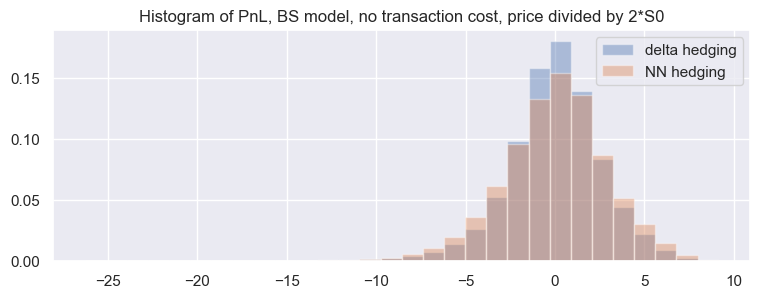

The MC simulation for PnL delta hedging at 95% confidence level is [-0.00,0.01], 
with mean 0.00 and variance 6.63
The MC simulation for PnL Neural Network hedging at 95% confidence level is [-0.00,0.01], 
with mean 0.00 and variance 8.36


In [27]:
histplot_and_compare(p_norm=p_norm, model=model_train.model, number_test=1000000, 
                     title='Histogram of PnL, BS model, no transaction cost, price divided by 2*S0')

In [28]:
# If we don't use this normalization for price, the training will be harder!
p_norm = 1 # here we set p_norm=1
dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                   divise_by=p_norm, device=device)
model_train = Model_train(N=N, size_input=1, size_output=1, hidden_layers=[16,],
                          device=device,lr=1e-3, epoch=30, early_stop_num=0, activation='relu',
                          price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                          pnl=pnl_calculation, # the pnl function
                          model=hedge_NN_recurrent_model, # we use the recurrent NN
                          dataloader=dataloader_bs, # the black scholes dataloader
                          loss=mseLoss() # we use the mseloss
                         )
model_train.train()

100%|████████████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.26s/it, epoch=30/30, epoch_loss=20.37737]


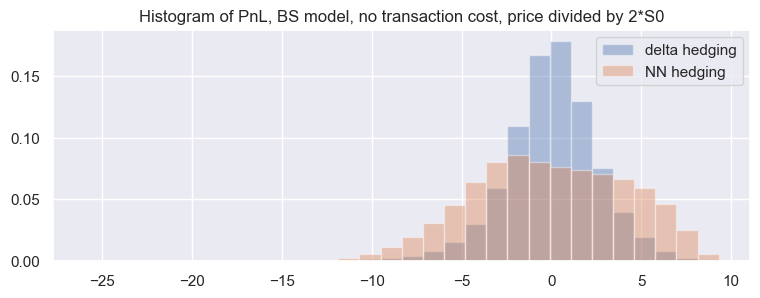

The MC simulation for PnL delta hedging at 95% confidence level is [-0.01,0.00], 
with mean -0.00 and variance 6.63
The MC simulation for PnL Neural Network hedging at 95% confidence level is [-0.01,0.01], 
with mean -0.00 and variance 20.08


In [29]:
histplot_and_compare(p_norm=p_norm, model=model_train.model, number_test=1000000, 
                     title='Histogram of PnL, BS model, no transaction cost, price divided by 2*S0')

**So if we don't do a simple normalization for price, (i.e. divided by S0*2), the neural network will be hard to train, and the variance without normalization is 20.08, which is very big, and the hedge is not good.**

<font color=black size=5 >1.5.2 The number of layer of neural network</font>

In [30]:
p_norm = 2*x0
models = dict()
for i in [1,2,3,4,5,6]:
    hidden_layers = [16, ]*i
    dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                       divise_by=p_norm, device=device)
    model_train = Model_train(N=N, size_input=1, size_output=1, 
                              hidden_layers=hidden_layers, 
                              device=device,lr=1e-3, epoch=30, early_stop_num=0, activation='relu',
                              price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                              pnl=pnl_calculation, # the pnl function
                              model=hedge_NN_recurrent_model, # we use the recurrent NN
                              dataloader=dataloader_bs, # the black scholes dataloader
                              loss=mseLoss() # we use the mseloss
                             )
    model_train.train()
    models[i] = model_train



100%|█████████████████████████████████████████████████████████████████████| 30/30 [01:41<00:00,  3.39s/it, epoch=30/30, epoch_loss=0.00017]


In [31]:
# We use new data set to test the different models
# Compare the mean and variance of Pnl (precision)
number_test = 100000
proba_mc = 0.95
test_loader = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=number_test, batch_size=number_test,
                                     divise_by=p_norm, device=device)
path_test, payoff_test = next(iter(test_loader))
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
mean, var, lower, upper = monte_carlo(pnl_bs,proba_mc)
print('For oracle delta hedging, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    mean, var, lower, upper = monte_carlo(pnl_NN,proba_mc)
    print('For [16,]*{} architecture, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(key, proba_mc, lower, upper, mean, var))

For oracle delta hedging, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.64
For [16,]*1 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 7.57
For [16,]*2 architecture, PnL at 95% level is [-0.03,0.01], with mean -0.01 and variance 7.78
For [16,]*3 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.02 and variance 6.94
For [16,]*4 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.69
For [16,]*5 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.93
For [16,]*6 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.66


In [32]:
# Compare the CVar of different models (robustness)
def calculate_cvar(pnl, alpha=0.05):
    sorted_pnl = np.sort(pnl)
    var_index = int(np.floor(alpha * len(sorted_pnl)))
    var = sorted_pnl[var_index]
    cvar = sorted_pnl[:var_index].mean()
    return var, cvar
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
var_01, cvar_01 = calculate_cvar(pnl_bs, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_bs, alpha=0.05)
print('For oracle delta hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(var_01, cvar_01, var_05, cvar_05))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    var_01, cvar_01 = calculate_cvar(pnl_NN, alpha=0.01)
    var_05, cvar_05 = calculate_cvar(pnl_NN, alpha=0.05)
    print('For [16,]*{} architecture, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(key, var_01, cvar_01, var_05, cvar_05))

For oracle delta hedging, PnL 1%Var:-7.32,CVar:-9.24;   5%Var:-4.31,CVar:-6.18
For [16,]*1 architecture, PnL 1%Var:-7.63,CVar:-9.33;   5%Var:-4.70,CVar:-6.51
For [16,]*2 architecture, PnL 1%Var:-7.64,CVar:-9.13;   5%Var:-4.85,CVar:-6.56
For [16,]*3 architecture, PnL 1%Var:-7.54,CVar:-9.30;   5%Var:-4.52,CVar:-6.38
For [16,]*4 architecture, PnL 1%Var:-7.30,CVar:-9.14;   5%Var:-4.38,CVar:-6.19
For [16,]*5 architecture, PnL 1%Var:-7.46,CVar:-9.26;   5%Var:-4.53,CVar:-6.34
For [16,]*6 architecture, PnL 1%Var:-7.39,CVar:-9.30;   5%Var:-4.34,CVar:-6.23


<font color=black size=5 >1.5.3 The size of hidden layer</font>

In [34]:
p_norm = 2*x0
models = dict()
for i in [4,8,16,32,64,128]:
    hidden_layers = [i, ] * 4
    dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                       divise_by=p_norm, device=device)
    model_train = Model_train(N=N, size_input=1, size_output=1, 
                              hidden_layers=hidden_layers, 
                              device=device,lr=1e-3, epoch=30, early_stop_num=0, activation='relu',
                              price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                              pnl=pnl_calculation, # the pnl function
                              model=hedge_NN_recurrent_model, # we use the recurrent NN
                              dataloader=dataloader_bs, # the black scholes dataloader
                              loss=mseLoss() # we use the mseloss
                             )
    model_train.train()
    models[i] = model_train


100%|█████████████████████████████████████████████████████████████████████| 30/30 [05:24<00:00, 10.81s/it, epoch=30/30, epoch_loss=0.00017]


In [37]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
mean, var, lower, upper = monte_carlo(pnl_bs,proba_mc)
print('For oracle delta hedging, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    mean, var, lower, upper = monte_carlo(pnl_NN,proba_mc)
    print('For [{},]*4 architecture, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(key, proba_mc, lower, upper, mean, var))

For oracle delta hedging, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.64
For [4,]*4 architecture, PnL at 95% level is [-0.03,0.01], with mean -0.01 and variance 8.07
For [8,]*4 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.92
For [16,]*4 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.79
For [32,]*4 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.82
For [64,]*4 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.70
For [128,]*4 architecture, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.93


In [38]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
var_01, cvar_01 = calculate_cvar(pnl_bs, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_bs, alpha=0.05)
print('For oracle delta hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(var_01, cvar_01, var_05, cvar_05))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    var_01, cvar_01 = calculate_cvar(pnl_NN, alpha=0.01)
    var_05, cvar_05 = calculate_cvar(pnl_NN, alpha=0.05)
    print('For [{},]*4 architecture, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(key, var_01, cvar_01, var_05, cvar_05))

For oracle delta hedging, PnL 1%Var:-7.32,CVar:-9.24;   5%Var:-4.31,CVar:-6.18
For [4,]*4 architecture, PnL 1%Var:-7.87,CVar:-9.51;   5%Var:-4.97,CVar:-6.77
For [8,]*4 architecture, PnL 1%Var:-7.45,CVar:-9.14;   5%Var:-4.51,CVar:-6.32
For [16,]*4 architecture, PnL 1%Var:-7.46,CVar:-9.33;   5%Var:-4.40,CVar:-6.27
For [32,]*4 architecture, PnL 1%Var:-7.34,CVar:-9.24;   5%Var:-4.32,CVar:-6.19
For [64,]*4 architecture, PnL 1%Var:-7.33,CVar:-9.19;   5%Var:-4.32,CVar:-6.18
For [128,]*4 architecture, PnL 1%Var:-7.55,CVar:-9.48;   5%Var:-4.54,CVar:-6.42


<font color=black size=5 >1.5.4 The activation function</font>

We know that, since we are considering a Put (or Call) option, the payoff function is actually a relu function, so naturally, the relu function would be better, but, since the approximation theory garanties that any usual function (e.g. sigmoid, tanh, leakyrelu) can also lead to a good results, we still need some experiments to compare the difference.

In [39]:
p_norm = 2*x0
models = dict()
for activation in ['relu', 'leakyrelu', 'sigmoid', 'tanh']:
    hidden_layers = [64, ] * 4
    dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                       divise_by=p_norm, device=device)
    model_train = Model_train(N=N, size_input=1, size_output=1, 
                              hidden_layers=hidden_layers, 
                              device=device,lr=1e-3, epoch=30, early_stop_num=0, 
                              activation=activation, # we add the activation function!
                              price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                              pnl=pnl_calculation, # the pnl function
                              model=hedge_NN_recurrent_model, # we use the recurrent NN
                              dataloader=dataloader_bs, # the black scholes dataloader
                              loss=mseLoss() # we use the mseloss
                             )
    model_train.train()
    models[activation] = model_train


100%|█████████████████████████████████████████████████████████████████████| 30/30 [03:19<00:00,  6.65s/it, epoch=30/30, epoch_loss=0.00017]


In [40]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
mean, var, lower, upper = monte_carlo(pnl_bs,proba_mc)
print('For oracle delta hedging, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    mean, var, lower, upper = monte_carlo(pnl_NN,proba_mc)
    print('For {} activ function, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(key, proba_mc, lower, upper, mean, var))

For oracle delta hedging, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.64
For relu activ function, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.66
For leakyrelu activ function, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.64
For sigmoid activ function, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.63
For tanh activ function, PnL at 95% level is [-0.03,0.00], with mean -0.01 and variance 6.92


In [41]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
var_01, cvar_01 = calculate_cvar(pnl_bs, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_bs, alpha=0.05)
print('For oracle delta hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(var_01, cvar_01, var_05, cvar_05))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    var_01, cvar_01 = calculate_cvar(pnl_NN, alpha=0.01)
    var_05, cvar_05 = calculate_cvar(pnl_NN, alpha=0.05)
    print('For {} activ function, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(key, var_01, cvar_01, var_05, cvar_05))

For oracle delta hedging, PnL 1%Var:-7.32,CVar:-9.24;   5%Var:-4.31,CVar:-6.18
For relu activ function, PnL 1%Var:-7.30,CVar:-9.13;   5%Var:-4.32,CVar:-6.15
For leakyrelu activ function, PnL 1%Var:-7.36,CVar:-9.27;   5%Var:-4.34,CVar:-6.21
For sigmoid activ function, PnL 1%Var:-7.34,CVar:-9.20;   5%Var:-4.34,CVar:-6.19
For tanh activ function, PnL 1%Var:-7.61,CVar:-9.57;   5%Var:-4.43,CVar:-6.37


<font color=black size=5 >1.5.5 Single model or different models for every time-step ? </font>

Actually, in this paper, the author compares 2 different method of building models
1. We build for each time-step a different model, which is "hedge_NN_different_model_1_dim" class below
2. We build only one (recurrent) model, each time we use the state and last time strategy as input, and the model will give the current strategy.

Now we will compare these two settings:

In [70]:
model_setting = {'single recurrent model': hedge_NN_recurrent_model_1_dim,
                 'different model':hedge_NN_different_model_1_dim,
                 }
p_norm = 2*x0
models = dict()
for model in model_setting:
    hidden_layers = [16, ] * 5
    dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                       divise_by=p_norm, device=device)
    model_train = Model_train(N=N, size_input=1, size_output=1, 
                              hidden_layers=hidden_layers, 
                              device=device,lr=1e-3, epoch=30, early_stop_num=0, 
                              activation='relu',
                              price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                              pnl=pnl_calculation, # the pnl function
                              model=model_setting[model],
                              dataloader=dataloader_bs, # the black scholes dataloader
                              loss=mseLoss() # we use the mseloss
                             )
    model_train.train()
    models[model] = model_train

100%|█████████████████████████████████████████████████████████████████████| 30/30 [01:30<00:00,  3.01s/it, epoch=30/30, epoch_loss=0.00017]


In [74]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
mean, var, lower, upper = monte_carlo(pnl_bs,proba_mc)
print('For oracle delta hedging, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    mean, var, lower, upper = monte_carlo(pnl_NN,proba_mc)
    print('For {}, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(key, proba_mc, lower, upper, mean, var))

For oracle delta hedging, PnL at 95% level is [-0.01,0.02], with mean 0.00 and variance 6.55
For single recurrent model, PnL at 95% level is [-0.02,0.02], with mean 0.00 and variance 6.85
For different model, PnL at 95% level is [-0.01,0.02], with mean 0.00 and variance 6.61


In [75]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
var_01, cvar_01 = calculate_cvar(pnl_bs, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_bs, alpha=0.05)
print('For oracle delta hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(var_01, cvar_01, var_05, cvar_05))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    var_01, cvar_01 = calculate_cvar(pnl_NN, alpha=0.01)
    var_05, cvar_05 = calculate_cvar(pnl_NN, alpha=0.05)
    print('For {}, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(key, var_01, cvar_01, var_05, cvar_05))

For oracle delta hedging, PnL 1%Var:-7.31,CVar:-9.02;   5%Var:-4.30,CVar:-6.11
For single recurrent model, PnL 1%Var:-7.26,CVar:-9.02;   5%Var:-4.46,CVar:-6.23
For different model, PnL 1%Var:-7.29,CVar:-9.01;   5%Var:-4.37,CVar:-6.15


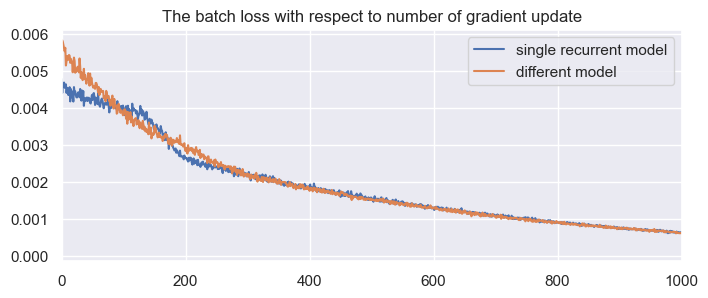

In [76]:
# We plot their loss: we can see that at the beginning, 
# the loss of single recurrent model converges more quickly
fig, ax = plt.subplots(figsize=(8,3))
for key in models:
    ax.plot(models[key].loss_iter, label=key)
ax.set_xlim(0, 1000)
ax.legend(); plt.title('The batch loss with respect to number of gradient update');plt.show()

<font color=black size=5 >1.5.6 CVar loss </font>

In this paper, the author also considered cvar loss, and here we will compare it.

In [98]:
loss_setting = {'MSE loss': mseLoss(),
                'CVar 99% loss': cvarLoss(0.99),
                'CVar 90% loss': cvarLoss(0.9),
                'CVar 50% loss': cvarLoss(0.5),
                 }
p_norm = 2*x0
models = dict()
for loss in loss_setting:
    hidden_layers = [16, ] * 5
    dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                       divise_by=p_norm, device=device)
    model_train = Model_train(N=N, size_input=1, size_output=1, 
                              hidden_layers=hidden_layers, 
                              device=device,lr=1e-3, epoch=30, early_stop_num=0, 
                              activation='relu',
                              price_option=price_put_BS(x0, T, r, sigma, K)/p_norm, # Suppose we know the price
                              pnl=pnl_calculation, # the pnl function
                              model=hedge_NN_recurrent_model,
                              dataloader=dataloader_bs, # the black scholes dataloader
                              loss=loss_setting[loss] # we use the mseloss
                             )
    model_train.train()
    models[loss] = model_train

100%|█████████████████████████████████████████████████████████████████████| 30/30 [01:25<00:00,  2.85s/it, epoch=30/30, epoch_loss=0.00979]


In [99]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
mean, var, lower, upper = monte_carlo(pnl_bs,proba_mc)
print('For oracle delta hedging, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(proba_mc, lower, upper, mean, var))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    mean, var, lower, upper = monte_carlo(pnl_NN,proba_mc)
    print('For {}, PnL at {:.0%} level is [{:.2f},{:.2f}], with mean {:.2f} and variance {:.2f}'.
         format(key, proba_mc, lower, upper, mean, var))

For oracle delta hedging, PnL at 95% level is [-0.01,0.02], with mean 0.00 and variance 6.62
For MSE loss, PnL at 95% level is [-0.01,0.02], with mean 0.00 and variance 6.75
For CVar 99% loss, PnL at 95% level is [-0.01,0.03], with mean 0.01 and variance 9.42
For CVar 90% loss, PnL at 95% level is [-0.01,0.02], with mean 0.01 and variance 7.46
For CVar 50% loss, PnL at 95% level is [-0.01,0.02], with mean 0.00 and variance 6.94


In [100]:
pnl_bs = p_norm * pnl_calculation(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
var_01, cvar_01 = calculate_cvar(pnl_bs, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_bs, alpha=0.05)
print('For oracle delta hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(var_01, cvar_01, var_05, cvar_05))
for key in models:
    pnl_NN = p_norm * pnl_calculation(path_test, payoff_test, models[key].model).detach().numpy().flatten()
    var_01, cvar_01 = calculate_cvar(pnl_NN, alpha=0.01)
    var_05, cvar_05 = calculate_cvar(pnl_NN, alpha=0.05)
    print('For {}, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(key, var_01, cvar_01, var_05, cvar_05))

For oracle delta hedging, PnL 1%Var:-7.28,CVar:-9.22;   5%Var:-4.30,CVar:-6.16
For MSE loss, PnL 1%Var:-7.28,CVar:-9.09;   5%Var:-4.41,CVar:-6.18
For CVar 99% loss, PnL 1%Var:-6.42,CVar:-7.52;   5%Var:-4.61,CVar:-5.74
For CVar 90% loss, PnL 1%Var:-6.69,CVar:-8.21;   5%Var:-4.33,CVar:-5.81
For CVar 50% loss, PnL 1%Var:-7.79,CVar:-9.76;   5%Var:-4.68,CVar:-6.62


<font color=black size=5 >1.6 With transaction cost</font>

In this article, a real-world setting is to consider the transaction cost.

Here we consider, as given in the paper, a proportional transaction cost: $c_{k}(\mathrm{n})=\sum_{i=1}^{d} \varepsilon\left|\mathrm{n}^{i}\right| S_{k}^{i}$. In this setting, we don't know the exact price, so we add the price as a parameter to learn for pytorch model.

In [46]:
def pnl_with_trans_cost(epsilon):
    '''We first define the PnL associated with a proportional transaction cost'''
    def pnl_calculation_with_trans_cost(path, payoff, model, epsilon=epsilon): 
        if path.dim() == 2:
            path = path.unsqueeze(-1)
        value = np.zeros_like(path[:,[0]])
        delta = []
        p0, delta0 = model(0, path[:,[0]])
        delta.append(delta0)
        value = p0 - torch.bmm(delta0.unsqueeze(1), path[:,[0]].transpose(1, 2)).squeeze(-1)
        for n in range(1,N):
            delta.append(model(n, path[:,[n]],delta[-1]))
            trade_cost = torch.bmm((delta[n] - delta[n-1]).unsqueeze(1), path[:,[n]].transpose(1, 2)).squeeze(-1)
            value = value - trade_cost - torch.abs(trade_cost) * epsilon
        value = value + torch.bmm(delta[N-1].unsqueeze(1), path[:,[N]].transpose(1, 2)).squeeze(-1) - payoff
        return value * np.exp(r*T)
    return pnl_calculation_with_trans_cost

In [47]:
p_norm = 2*x0
epsilon = 0.05
dataloader_bs = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12,
                                   divise_by=p_norm, device=device)
model_train = Model_train(N=N, size_input=1, size_output=1, hidden_layers=[64,]*4, 
                          device=device, lr=1e-3, epoch=100, early_stop_num=0, 
                          pnl=pnl_with_trans_cost(epsilon=epsilon), 
                          price_option = None,
                          model=hedge_NN_recurrent_model,
                          dataloader=dataloader_bs,
                          activation='relu',
                          loss=mseLoss()
                         )
model_train.train()
# price comparasion
print('The price given by neural network with transaction cost {} is: {:.4f}'.\
      format(epsilon, model_train.model.state_dict()['price'].item() * p_norm))
print('The exact price given by BS formula (without transaction cost) is : {:.4f}'.\
      format(price_put_BS(x0, T, r, sigma, K)))


100%|█████████████████████████████████████████████████████████████████| 100/100 [09:19<00:00,  5.60s/it, epoch=100/100, epoch_loss=0.00021]

The price given by neural network with transaction cost 0.05 is: 9.2930
The exact price given by BS formula (without transaction cost) is : 5.4595


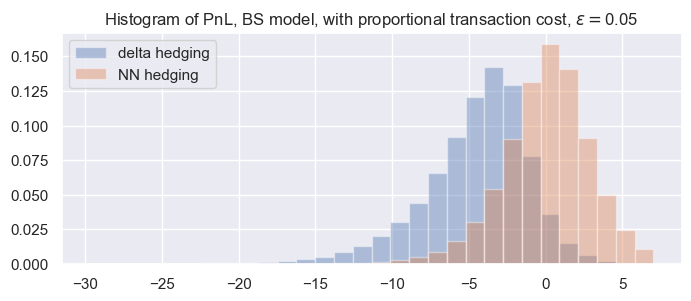

In [48]:
test_loader = Dataloader_simu_BS(x0, K, N, T, r, sigma, M=100000, batch_size=100000,
                                 divise_by=p_norm, device=device)
path_test, payoff_test = next(iter(test_loader))

with torch.no_grad():
    pnl_bs = p_norm * pnl_with_trans_cost(epsilon=epsilon)(path_test, payoff_test, bs_hedge(p_norm)).detach().numpy().flatten()
    pnl_NN = p_norm * pnl_with_trans_cost(epsilon=epsilon)(path_test, payoff_test, model_train.model).detach().numpy().flatten()

_, bins = np.histogram(pnl_bs, bins=30)
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(pnl_bs, bins=bins, density=True, alpha=0.4, label="delta hedging")
ax.hist(pnl_NN, bins=bins, density=True, alpha=0.4, label="NN hedging")
ax.legend()
plt.title('Histogram of PnL, BS model, with proportional transaction cost, $\epsilon=${}'.format(epsilon))
plt.show()

In [49]:
p = 0.95
mean, var, lower, upper = monte_carlo(pnl_bs,p)
print('The MC simulation for PnL delta hedging at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f} \n'.
     format(p, lower, upper, mean, var))
mean, var, lower, upper = monte_carlo(pnl_NN,p)
print('The MC simulation for PnL Neural Network hedging at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f}'.
     format(p, lower, upper, mean, var))

The MC simulation for PnL delta hedging at 95% confidence level is [-4.52,-4.48], 
with mean -4.50 and variance 11.86 

The MC simulation for PnL Neural Network hedging at 95% confidence level is [0.02,0.06], 
with mean 0.04 and variance 8.42


In [50]:
var_01, cvar_01 = calculate_cvar(pnl_bs, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_bs, alpha=0.05)
print('For delta hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
         format(var_01, cvar_01, var_05, cvar_05))
var_01, cvar_01 = calculate_cvar(pnl_NN, alpha=0.01)
var_05, cvar_05 = calculate_cvar(pnl_NN, alpha=0.05)
print('For NN deep hedging, PnL 1%Var:{:.2f},CVar:{:.2f};   5%Var:{:.2f},CVar:{:.2f}'.
     format(var_01, cvar_01, var_05, cvar_05))


For delta hedging, PnL 1%Var:-14.98,CVar:-17.32;   5%Var:-10.88,CVar:-13.41
For NN deep hedging, PnL 1%Var:-8.14,CVar:-10.24;   5%Var:-4.93,CVar:-6.94


In this time, the deep hedging network is better than the vanilla delta hedging in terms of the average PnL, the variance, as well as the var and cvar, so deep hedging is valid in the case of transaction cost.

<font color=black size=6 >2. Heston Model, Put, d=2</font>

In this article, the author proves that the deep hedging is actually model-free, and experiments show that it is valid under the Heston Model assumption, so we also verify this model.

We first did a research about generating of Heston model.

**1. Simulation of the Cox-Ingersoll-Ross Model**

This Python function `generate_CIR_paths` is designed to simulate paths of the Cox-Ingersoll-Ross (CIR) model, a common stochastic process used in financial mathematics to model interest rates or volatility. The CIR model is described by the following stochastic differential equation (SDE):

$$
dV_t = \alpha (b - V_t) dt + \sigma \sqrt{V_t} dW_t
$$

where:
- $\alpha$ is the speed of mean reversion,
- $b$ is the long-term mean level,
- $\sigma$ is the volatility,
- $V_t$ is the process value at time $t$,
- $dW_t$ represents the increments of a Wiener process.

**Key Variables and Calculation:**
- `alpha, b, sigma`: Parameters of the CIR model defining the dynamics of the variance.
- `dt`: The time increment.
- `v_0`: The initial variance at time 0.
- `T`: The total number of time steps for which the path is simulated.

The simulation employs an exact method based on the non-central chi-squared distribution to ensure the non-negativity and correct variance dynamics of the process. The main computational steps include:
- `d` is calculated as $d = \frac{4b\alpha}{\sigma^2}$, determining the degrees of freedom for the non-central chi-squared distribution.
- `c` is a scaling factor defined by $c = \frac{\sigma^2 (1 - e^{-\alpha dt})}{4\alpha}$, which adjusts the variance of the process to match the theoretical model.
- If $d > 1$, the non-central chi-squared distribution parameters are straightforward. If $d \leq 1$, additional calculations involving Poisson and adjusted chi-squared distributions are necessary to correctly simulate the CIR process.


**2. Simulation of the Heston Model**

This Python function `generate_Heston_paths` is designed to simulate the paths of the Heston model, a widely-used stochastic volatility model in financial mathematics. The Heston model is especially useful for options pricing as it incorporates both stochastic returns and stochastic volatility. The model is defined by the following coupled stochastic differential equations (SDEs):

$$
dS_t = r S_t dt + S_t \sqrt{V_t} dW_t
$$
$$
dV_t = \alpha (b - V_t) dt + \sigma \sqrt{V_t} dZ_t
$$
$$
\text{corr}(dW_t, dZ_t) = \rho
$$

where:
- $S_t$ represents the stock price process,
- $V_t$ represents the variance process,
- $r$ is the risk-free interest rate,
- $\rho$ is the correlation between the Brownian motions $dW_t$ and $dZ_t$ affecting the stock price and variance, respectively.

**Key Variables and Calculation:**
- `M`: Number of paths to simulate.
- `S0`: Initial stock price.
- `rho`: Correlation between the two Brownian motions.
- `r`: Annual risk-free rate.
- `alpha, b, sigma`: Parameters for the variance process ($V_t$), similar to those in the CIR model.
- `dt`: Time increment.
- `v_0`: Initial variance.
- `T`: Number of time steps to simulate.
- `rng`: Seed for random number generation to ensure reproducibility.

To simulate:
- First, generate paths for the variance process $V_t$ using the `generate_CIR_paths` function.
- Then simulate the log of the stock price process, adjusting for stochastic volatility and the correlation between the price and variance processes.
- The log-price equation incorporates terms to adjust for the risk-free rate, mean reversion in volatility, and the stochastic components of the volatility.

In [51]:
def generate_CIR_paths(M, alpha, b, sigma, dt, v_0, N, rng):
    '''
    Implements exact Cox-Ingersoll-Ross / square-root diffusion process
    We use the same method metionned in article Glasserman (2004)
    '''
    Vts = np.zeros((M, N + 1))
    Vts[:,0] = v_0
    d = 4 * b * alpha / sigma ** 2
    c = sigma ** 2  * (1 - np.exp(-alpha * dt)) / (4 * alpha)
    if d > 1:
        Zs = rng.random_normal(size=(M, N + 1))
        chi_sqs = rng.chisquare (df = d - 1, size=(M, N + 1))
    else:
        poissons = np.zeros((M, N + 1))
        chi_sqs = np.zeros((M, N + 1))
    for i in range(M):
        for t in range(N):    
            l = Vts[i, t] * np.exp(-alpha * dt) / c
            if d > 1:
                Vts[i, t + 1] = c * ((Zs[i, t] + np.sqrt(l)) ** 2 + chi_sqs[i, t])
            else:
                poissons[i, t] = rng.poisson(lam = l / 2)
                chi_sqs[i, t] = rng.chisquare(df = d + 2 * poissons[i, t])
                Vts[i, t + 1] = c * chi_sqs[i, t]
    return Vts
        
def generate_Heston_paths(M, S0, rho, r, alpha, b, sigma, dt, v_0, N, rng):
    '''
    Based sur CIR function for vol, 
    we write a function to generate the Heston paths of S and V
    '''
    Zs = rng.standard_normal(size = (M, N)) # random normal increments
    Zs = (Zs - Zs.mean(axis= 0)) / Zs.std(axis = 0)

    # pre-generate Vts
    Vts = generate_CIR_paths(M = M, alpha = alpha, 
                             b = b, sigma = sigma, 
                             dt = dt, v_0 = v_0, N = N, rng = rng)

    # simulate the log-price process
    log_Sts = np.zeros((M, N + 1))
    log_Sts[:, 0] = np.log(S0)

    k0 = (r - rho / sigma * alpha * b) * dt
    k1 = (rho * alpha / sigma - 0.5) * dt - rho / sigma
    k2 = rho / sigma

    for i in range(N):
        log_Sts[:, i + 1] = (log_Sts[:,i] + k0 + k1 * Vts[:,i] + k2 * Vts[:,i+1] + 
                              np.sqrt((1.0 - rho ** 2) * Vts[:,i]) * np.sqrt(dt) * Zs[:, i])
    return np.exp(log_Sts), Vts

In [52]:
class Dataloader_simu_Heston(Dataloader_simu_BS):
    '''generate Heston path and payoff for neural network to train'''
    def __init__(self, x0, K, N, T, r, sigma, M, batch_size, divise_by, 
                 alpha, b, rho, sigma_V, v0,
                 device='cpu', option='put'):
        super().__init__(x0, K, N, T, r, sigma, M, batch_size, divise_by, device, option=option)
        self.alpha = alpha
        self.b = b
        self.rho = rho
        self.sigma_V = sigma_V
        self.v0 = v0

    def generate_path_payoff(self):
        S, V = generate_Heston_paths(self.M, self.x0, self.rho, self.r,
                                             self.alpha, self.b, self.sigma_V, self.dt, 
                                             self.v0, self.N, self.rng)
        path_S1 = torch.tensor(S, dtype=torch.float, device=self.device)
        path_V = torch.tensor(V, dtype=torch.float, device=self.device)
        
        integral_V = torch.cumsum(path_V, dim=1) * self.dt - self.v0 * self.dt
        # Calculate L(t, Vt) for all t
        term1 = (path_V - self.b) / self.alpha
        term2 = (1 - torch.exp(-self.alpha * (self.T - torch.arange(self.N+1) * self.dt))) 
        L_t_Vt = term1 * term2 + self.b * (self.T - torch.arange(self.N+1) * self.dt)
        # Calculate S^2_t
        path_S2 = integral_V + L_t_Vt
        # concat S1 and S2
        path_S = torch.stack((path_S1, path_S2), dim=2)
        if self.option=='call':
            payoff = (np.exp(-self.r * self.T) *\
                      torch.relu(np.exp(self.r * self.T) * path_S1[:, self.N] - self.K))[:, None]
        else:
            payoff = (np.exp(-self.r * self.T) *\
                      torch.relu(self.K - np.exp(self.r * self.T) * path_S1[:, self.N]))[:, None]
        return path_S / self.divise_by, payoff / self.divise_by

For Heston model, we use the same parameters as given in the paper:

In [53]:
# the hyperparameters for heston model
alpha=1; b=0.04; rho=-0.7; sigma_V=2; v0=0.04

**Under Heston model, this is actually a 2-dimension underlying, as shown in paper:**

$S^{1}$ is the price of a liquidly tradeable asset and V is the (stochastic) variance process of $S^{1}$ , modeled by a Cox-Ingersoll-Ross (CIR) process. V itself is not tradable directly, but only through options on variance. In our framework this is modeled by an idealized variance swap with maturity T, i.e. we set  $\mathcal{F}_{t}^{H}:=\sigma\left(\left(S_{s}^{1}, V_{s}\right): s \in[0, t]\right)$  and $S_{t}^{2}:=\mathbb{E}_{\mathbb{Q}}\left[\int_{0}^{T} V_{s} \mathrm{~d} s \mid \mathcal{F}_{t}^{H}\right], \quad t \in[0, T]$,

Therefore, we can consider $\left(S^{1}, S^{2}\right)$ as the prices of liquidly tradeable assets. 

The author also gives the formula for $S_{t}^{2}$:

$$S_{t}^{2}=\int_{0}^{t} V_{s} \mathrm{~d} s+L\left(t, V_{t}\right)$$

where

$$L(t, v)=\frac{v-b}{\alpha}\left(1-e^{-\alpha(T-t)}\right)+b(T-t)$$

So we use the formula in the paper to calculate $S^{2}$, and treat this case as a 2-dimension underlying.


**Option pricing by Monte Carlo simulation:**

In [83]:
test_loader = Dataloader_simu_Heston(x0, K, N, T, r, sigma, M=5000000, batch_size=5000000, 
                                       divise_by=p_norm, device=device,
                                       alpha=1, b=0.04, rho=-0.7, sigma_V=2, v0=0.04, option='put'
                                      )
_, payoff_test = next(iter(test_loader))
payoff_test = payoff_test.squeeze().numpy() * p_norm
p = 0.95
mean, var, lower, upper = monte_carlo(payoff_test, p)
print('The MC simulation for this Heston payoff hedging at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f}'.
     format(p, lower, upper, mean, var))

The MC simulation for this Heston payoff hedging at 95% confidence level is [1.58,1.59], 
with mean 1.58 and variance 74.23


In [84]:
dimension = 2
dataloader_heston = Dataloader_simu_Heston(x0, K, N, T, r, sigma, M=2**20, batch_size=2**12, 
                                       divise_by=p_norm, device=device,
                                       alpha=alpha, b=b, rho=rho, sigma_V=sigma_V, v0=v0
                                      )
model_train = Model_train(N=N, size_input=dimension, size_output=dimension, device='cpu', 
                          hidden_layers=[16,] * 4, 
                          lr=1e-3, epoch=50, early_stop_num=0, 
                          price_option = 1.58 / p_norm,
                          pnl=pnl_calculation, 
                          model=hedge_NN_recurrent_model,
                          dataloader=dataloader_heston,
                          activation='relu',
                          loss=mseLoss()
                         )
model_train.train()

100%|█████████████████████████████████████████████████████████████████████| 50/50 [18:16<00:00, 21.92s/it, epoch=50/50, epoch_loss=0.00020]


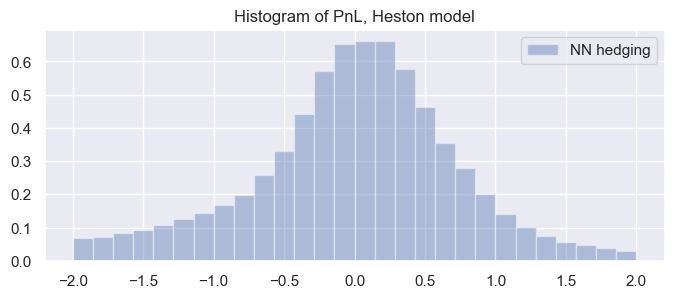

The MC simulation for PnL Neural Network hedging at 95% confidence level is [-0.42,-0.39], 
with mean -0.41 and variance 7.77


In [91]:
test_loader = Dataloader_simu_Heston(x0, K, N, T, r, sigma, M=100000, batch_size=100000, 
                                       divise_by=p_norm, device=device,
                                       alpha=1, b=0.04, rho=-0.7, sigma_V=2, v0=0.04
                                      )
path_test, payoff_test = next(iter(test_loader))

with torch.no_grad():
    pnl_NN = p_norm*model_train.pnl(path_test, payoff_test).detach().numpy().flatten()

_, bins = np.histogram(pnl_bs, bins=30)
bins = np.linspace(-2,2,29)
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(pnl_NN, bins=bins, density=True, alpha=0.4, label="NN hedging")
ax.legend()
plt.title('Histogram of PnL, Heston model')
plt.savefig('./histogram_pnl_Heston_hedging.jpg')
plt.show()


p = 0.95
mean, var, lower, upper = monte_carlo(pnl_NN,p)
print('The MC simulation for PnL Neural Network hedging at {:.0%} confidence level is [{:.2f},{:.2f}], \n'
      'with mean {:.2f} and variance {:.2f}'.
     format(p, lower, upper, mean, var))